<a href="https://colab.research.google.com/github/ebsenthil/langgraph-agent-class2/blob/main/smart_travel_assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain_openai
!pip install langchain_community
!pip install pyowm
!pip install langgraph
!pip install tavily-python
!pip install amadeus

In [5]:
from langchain.tools import tool
import requests
from datetime import datetime, timedelta
import os

In [6]:
# Access the secret
from google.colab import userdata

tavily_api_key = userdata.get('TAVILY_API_KEY')
openai_api_key = userdata.get('OPENAI_API_KEY')
OPENWEATHERMAP_API_KEY=userdata.get('OPENWEATHERMAP_API_KEY')
# Retrieve API Key securely (you can also use os.environ.get("TAVILY_API_KEY") if running locally)
TAVILY_API_KEY = userdata.get("TAVILY_API_KEY")
#Retrive API Key for Amadeus
amadeus_api_key = userdata.get("AMADEUS_API_KEY")
amadeus_api_secret = userdata.get("AMADEUS_API_SECRET")

In [7]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo",api_key=openai_api_key)  # or "gpt-3.5-turbo"
response = llm.invoke("hi")
print(response.content)

Hello! How can I assist you today?


In [8]:
@tool
def get_weather_current(city:str) -> str:
    """
    Provide weather forecast for a given city.
    Args:
        city (str): The name of the city to get the weather forecast for.
    Returns:
        str: The weather forecast for the specified city.
    """
    return weather.run(city)



@tool
def get_weather_forcast(city: str, start: str, end: str) -> str:
    """
    Fetches weather for a city from start to end dates using WeatherAPI.com.
    - Uses forecast.json for ranges up to 14 days.
    - Uses future.json per-day for dates 15–300 days ahead.
    """
    # 🧾 1. Parse and validate dates
    try:
        s = datetime.strptime(start, "%Y-%m-%d").date()
        e = datetime.strptime(end, "%Y-%m-%d").date()
    except ValueError:
        return "❗ Invalid date format. Use YYYY-MM-DD."

    if e < s:
        return "❗ End date must be same or after the start date."

    weatherai_api_key=userdata.get("WEATHERAI_API_KEY")
    lines = []

    # 📆 2. Use forecast.json for up to 14 days from today
    today = datetime.today().date()
    if s <= today + timedelta(days=13):
        days_needed = min((e - s).days + 1, 14)
        url = "http://api.weatherapi.com/v1/forecast.json"
        params = {"key": weatherai_api_key, "q": city, "days": days_needed, "aqi": "no", "alerts": "no"}
        resp = requests.get(url, params=params)
        if resp.status_code != 200:
            return f"API error {resp.status_code}: {resp.text}"
        data = resp.json()
        for day in data.get("forecast", {}).get("forecastday", []):
            date = day["date"]
            cond = day["day"]["condition"]["text"]
            icon = "https:" + day["day"]["condition"]["icon"]
            maxt = day["day"]["maxtemp_c"]
            mint = day["day"]["mintemp_c"]
            if s <= datetime.strptime(date, "%Y-%m-%d").date() <= e:
                lines.append(f"{date}: {cond}, High: {maxt}°C, Low: {mint}°C, Icon: {icon}")

    # 🔭 3. Use future.json for dates >14 days ahead
    cursor = max(s, today + timedelta(days=14))
    while cursor <= e and (cursor - today).days <= 300:
        url = "http://api.weatherapi.com/v1/future.json"
        params = {"key": weatherai_api_key, "q": city, "dt": cursor.isoformat()}
        resp = requests.get(url, params=params)
        if resp.status_code != 200:
            lines.append(f"{cursor}: API error {resp.status_code}")
        else:
            day = resp.json().get("forecast", {}).get("forecastday", [{}])[0]
            cond = day["day"]["condition"]["text"]
            icon = "https:" + day["day"]["condition"]["icon"]
            maxt = day["day"]["maxtemp_c"]
            mint = day["day"]["mintemp_c"]
            lines.append(f"{cursor}: {cond}, High: {maxt}°C, Low: {mint}°C, Icon: {icon}")
        cursor += timedelta(days=1)

    if not lines:
        return f"No forecastable dates in range {start} to {end} (max 300 days ahead)."

    return "\n".join(lines)





In [9]:
# Tavily tool
from tavily import TavilyClient

client = TavilyClient(api_key=TAVILY_API_KEY)

@tool
def search_top_attractions(city: str) -> str:
    """
    Search top attractions and activities in a city using Tavily Search API.
    Returns a summary string.
    """
    query = f"Top five tourist attractions and top five activities in {city}"
    try:
        response = client.search(query=query, search_depth="advanced", include_answer=True)
        return response.get("answer", "No summary available.")
    except Exception as e:
        return f"Error during search: {e}"


In [10]:
from google.colab import userdata # We can use this to explicitly verify, though os.getenv usually works
from langchain.tools import tool
import requests
import os

# Load API key from .env file
EXCHANGE_API_KEY = userdata.get("EXCHANGE_API_KEY")

@tool
def convert_currency(amount: float, from_currency: str, to_currency: str) -> str:
    """
    Converts the specified amount from one currency to another using ExchangeRate-API.

    Parameters:
    - amount: Amount to convert (e.g., 100)
    - from_currency: Base currency code (e.g., "USD")
    - to_currency: Target currency code (e.g., "INR")

    Returns:
    - A string with the converted amount.
    """
    try:
        url = f"https://v6.exchangerate-api.com/v6/{EXCHANGE_API_KEY}/pair/{from_currency}/{to_currency}/{amount}"
        response = requests.get(url)
        data = response.json()

        if data["result"] == "success":
            converted = data["conversion_result"]
            rate = data["conversion_rate"]
            return f"{amount} {from_currency} = {converted:.2f} {to_currency} (Rate: {rate})"
        else:
            return f"❌ Error: {data.get('error-type', 'Unknown error')}"
    except Exception as e:
        return f"❌ Exception: {str(e)}"


In [11]:
from amadeus import Client, ResponseError
import os
from datetime import date, timedelta, datetime
import json


amadeus = Client(
    client_id=amadeus_api_key,
    client_secret=amadeus_api_secret
)

@tool
def search_hotels(city_code: str, checkin: str, checkout: str, adults: int = 1) -> str:
    """
    Search hotels in a city for given date range using Amadeus API.

    Args:
        city_code: IATA city code (e.g., 'NYC', 'PAR', 'LON')
        checkin: Check-in date in YYYY-MM-DD format
        checkout: Check-out date in YYYY-MM-DD format
        adults: Number of adults (default: 1)

    Returns:
        Formatted string of hotel options with prices
    """
    try:
        # Validate date format
        datetime.strptime(checkin, '%Y-%m-%d')
        datetime.strptime(checkout, '%Y-%m-%d')

        # First get hotels in the city
        hotels_response = amadeus.reference_data.locations.hotels.by_city.get(
            cityCode=city_code
        )

        if not hotels_response.data:
            return f"No hotels found in {city_code}"

        # Get hotel IDs from more hotels to increase chances of getting offers
        hotel_ids = [hotel['hotelId'] for hotel in hotels_response.data[:30]]

        # Try searching all hotels at once first
        try:
            response = amadeus.shopping.hotel_offers_search.get(
                hotelIds=','.join(hotel_ids),
                checkInDate=checkin,
                checkOutDate=checkout,
                adults=adults,
                roomQuantity=1
            )

            if response.data and len(response.data) > 1:
                # If we got multiple results, use them
                all_offers = response.data
            else:
                # If only one or no results, try batch approach
                all_offers = []
                batch_size = 5  # Smaller batches

                for i in range(0, min(len(hotel_ids), 15), batch_size):  # Try first 15 hotels
                    batch_ids = hotel_ids[i:i+batch_size]
                    try:
                        batch_response = amadeus.shopping.hotel_offers_search.get(
                            hotelIds=','.join(batch_ids),
                            checkInDate=checkin,
                            checkOutDate=checkout,
                            adults=adults,
                            roomQuantity=1
                        )
                        if batch_response.data:
                            all_offers.extend(batch_response.data)
                    except ResponseError as batch_error:
                        continue

        except ResponseError as error:
            # If bulk search fails, try batch approach
            all_offers = []
            batch_size = 5

            for i in range(0, min(len(hotel_ids), 15), batch_size):
                batch_ids = hotel_ids[i:i+batch_size]
                try:
                    batch_response = amadeus.shopping.hotel_offers_search.get(
                        hotelIds=','.join(batch_ids),
                        checkInDate=checkin,
                        checkOutDate=checkout,
                        adults=adults,
                        roomQuantity=1
                    )
                    if batch_response.data:
                        all_offers.extend(batch_response.data)
                except ResponseError as batch_error:
                    continue

        if not all_offers:
            return f"No hotel offers available in {city_code} for {checkin} to {checkout}. This might be due to high demand, booking restrictions, or limited availability for the selected dates."

        # Use all_offers instead of response.data
        response = type('MockResponse', (), {'data': all_offers})()

        if not response.data:
            return f"No hotels found in {city_code} for {checkin} to {checkout}"

        hotels = response.data[:10]  # Top 10 results instead of 5
        result = []

        for i, hotel in enumerate(hotels, 1):
            try:
                hotel_info = hotel['hotel']
                name = hotel_info.get('name', 'Unknown Hotel')

                # Get best offer
                offers = hotel.get('offers', [])
                if offers:
                    best_offer = offers[0]
                    price_info = best_offer.get('price', {})
                    total_price = price_info.get('total', 'N/A')
                    currency = price_info.get('currency', '')

                    # Get room details
                    room_info = best_offer.get('room', {})
                    room_type = room_info.get('typeEstimated', {}).get('category', 'Standard')

                    # Rating if available
                    rating = hotel_info.get('rating', 'Not rated')

                    result.append(
                        f"{i}. {name}\n"
                        f"   Price: {total_price} {currency}\n"
                        f"   Room: {room_type}\n"
                        f"   Rating: {rating}\n"
                    )
                else:
                    result.append(f"{i}. {name} - No offers available\n")

            except KeyError as e:
                result.append(f"{i}. Hotel data incomplete - {str(e)}\n")

        return "\n".join(result)

    except ResponseError as error:
        return f"Amadeus API Error: {error.response.body}"
    except ValueError as e:
        return f"Date format error: {str(e)}. Use YYYY-MM-DD format."
    except Exception as e:
        return f"Error fetching hotel info: {str(e)}"

In [12]:

from langchain_community.utilities import OpenWeatherMapAPIWrapper
weather = OpenWeatherMapAPIWrapper(openweathermap_api_key=OPENWEATHERMAP_API_KEY)

In [13]:
weather_data = weather.run("bangalore,IN")
print(weather_data)

In bangalore,IN, the current weather is as follows:
Detailed status: broken clouds
Wind speed: 5.14 m/s, direction: 230°
Humidity: 89%
Temperature: 
  - Current: 21.5°C
  - High: 21.94°C
  - Low: 20.62°C
  - Feels like: 22.03°C
Rain: {}
Heat index: None
Cloud cover: 75%


In [14]:
tools = [get_weather_current,get_weather_forcast,search_top_attractions,search_hotels,convert_currency]
llm_with_tools=llm.bind_tools(tools)

In [15]:
response=llm_with_tools.invoke("find hotel in chennai for sep 10th 2025")

In [16]:
response.content

''

In [17]:
response.tool_calls

[{'name': 'search_hotels',
  'args': {'city_code': 'MAA',
   'checkin': '2025-09-10',
   'checkout': '2025-09-11'},
  'id': 'call_KVEEdEMGxn3O6pTJs88oYAaG',
  'type': 'tool_call'}]

In [ ]:
SYSTEM_PROMPT="You are a helpful assistant tasked with providing current weather information on specific city in a given country code or provide weather forecast for specific city in specific date range which is in the format of YYYY-MM-DD.Also if you need to provide top tourist attractions, major recreational activities for tourists, provide details of major restaurants when user asks such questions. Search hotel for the date range in the city and provide recommendations as per the user ask. Also you may need to provide currency conversion as well and provide complete travel summary that includes hotel cost and other expenses. Also you need to prepare iternarary if user asks for travel plan"

In [18]:
SYSTEM_PROMPT = """
You are a helpful and knowledgeable travel assistant. Your primary responsibility is to provide users with accurate, timely, and contextual travel-related information and services. Your capabilities include:

1. **Weather Information**:
   - Provide current weather conditions for a given city and country code.
   - Offer weather forecasts for a specific city within a given date range (format: YYYY-MM-DD).

2. **Tourist Attractions & Activities**:
   - Suggest the top tourist attractions in a specified city.
   - Recommend major recreational and cultural activities suitable for tourists.

3. **Restaurant Recommendations**:
   - Provide details about top-rated restaurants in the city, including cuisine type and suitability for different preferences (e.g., vegetarian, budget-friendly, luxury dining).

4. **Hotel Search & Recommendations**:
   - Search for available hotels in a city within a given check-in and check-out date.
   - Include hotel name, price, rating, room type, and location.
   - Tailor recommendations based on user criteria (budget, rating, etc.).

5. **Currency Conversion**:
   - Convert amounts between different currencies using up-to-date exchange rates when requested.

6. **Travel Itinerary Generation**:
   - Generate a detailed multi-day travel itinerary based on user preferences, including:
     - Daily plans with activities and attractions
     - Hotel check-in/check-out details
     - Suggestions for meals and free time

7. **Travel Summary**:
   - Provide a summarized travel plan that includes:
     - Estimated hotel costs
     - Activity and entry fees (if available)
     - Estimated food and local transportation expenses
     - Total estimated cost in user’s preferred currency

You must be context-aware, follow user instructions accurately, and always format responses in a clear and user-friendly way. If any required information is missing, kindly ask the user for clarification.
"""


In [19]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState,StateGraph, END, START

In [20]:
def function_1(state:MessagesState):

    user_question=state["messages"]

    input_question = [SYSTEM_PROMPT]+user_question

    response = llm_with_tools.invoke(input_question)

    return {
        "messages":[response]
    }

In [21]:
builder=StateGraph(MessagesState)
builder.add_node("llm_decision_step",function_1)

In [22]:
from langgraph.prebuilt import ToolNode
builder.add_node("tools",ToolNode(tools))

In [23]:
builder.add_edge(START,"llm_decision_step")

In [24]:
from langgraph.prebuilt import tools_condition
builder.add_conditional_edges(
    "llm_decision_step",
    tools_condition,
)

In [25]:
builder.add_edge("tools","llm_decision_step")

In [26]:
react_graph=builder.compile()

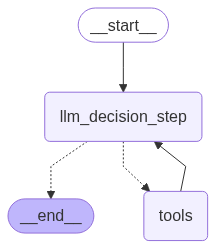

In [27]:
from IPython.display import Image, display
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [32]:
message=[HumanMessage(content="I need to travel from chennai to Mumbai on 11th august 2025 for 2 days with my wife , can I travel, weather is ok?, what can I do there and where can I stay, provide me complete travel plan. ")]

In [34]:
weather_result=react_graph.invoke({"messages":message})

In [35]:
weather_result

{'messages': [HumanMessage(content='I need to travel from chennai to Mumbai on 11th august 2025 for 2 days with my wife , can I travel, weather is ok?, what can I do there and where can I stay, provide me complete travel plan. ', additional_kwargs={}, response_metadata={}, id='acebf7ea-4be2-4739-8886-7b068fa66103'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8RohMzPTeWDFHCI0DMEFLm2g', 'function': {'arguments': '{"city": "Mumbai", "start": "2025-08-11", "end": "2025-08-12"}', 'name': 'get_weather_forcast'}, 'type': 'function'}, {'id': 'call_spljvNkIUNrTmCKIheYclxfo', 'function': {'arguments': '{"city": "Mumbai"}', 'name': 'search_top_attractions'}, 'type': 'function'}, {'id': 'call_HBZI2SLqcZrySWFRGAIJG0bF', 'function': {'arguments': '{"city_code": "BOM", "checkin": "2025-08-11", "checkout": "2025-08-13", "adults": 2}', 'name': 'search_hotels'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 108, 'prompt_tokens

In [36]:
for m in weather_result["messages"]:
    m.pretty_print()

================================ Human Message =================================

I need to travel from chennai to Mumbai on 11th august 2025 for 2 days with my wife , can I travel, weather is ok?, what can I do there and where can I stay, provide me complete travel plan. 
================================== Ai Message ==================================
Tool Calls:
  get_weather_forcast (call_8RohMzPTeWDFHCI0DMEFLm2g)
 Call ID: call_8RohMzPTeWDFHCI0DMEFLm2g
  Args:
    city: Mumbai
    start: 2025-08-11
    end: 2025-08-12
  search_top_attractions (call_spljvNkIUNrTmCKIheYclxfo)
 Call ID: call_spljvNkIUNrTmCKIheYclxfo
  Args:
    city: Mumbai
  search_hotels (call_HBZI2SLqcZrySWFRGAIJG0bF)
 Call ID: call_HBZI2SLqcZrySWFRGAIJG0bF
  Args:
    city_code: BOM
    checkin: 2025-08-11
    checkout: 2025-08-13
    adults: 2
================================= Tool Message =================================
Name: get_weather_forcast

2025-08-11: Moderate or heavy rain shower, High: 28.5°C, Low: 26

In [37]:
from IPython.display import Markdown, display

response = weather_result["messages"][-1].content
display(Markdown(response))  # For Jupyter or Colab


### Travel Plan for Chennai to Mumbai Trip on August 11-13, 2025

#### Weather Forecast:
- **August 11, 2025:** Moderate or heavy rain shower, High: 28.5°C, Low: 26.2°C
- **August 12, 2025:** Moderate or heavy rain shower, High: 28.6°C, Low: 26.1°C

#### Things to Do in Mumbai:
- **Top Tourist Attractions:** Gateway of India, Marine Drive, Chhatrapati Shivaji Terminus, Elephanta Caves, Bandra Worli Sea Link
- **Top Activities:** Sightseeing, Beach visits, Cultural tours, Shopping, Dining

#### Hotel Options:
1. **Holiday Inn Mumbai International Airport**
   - Price: 21147.96 INR
   - Room: Standard Room
   - Rating: Not rated

2. **The Westin Mumbai Garden City**
   - Price: 44250.00 INR
   - Room: Deluxe Room
   - Rating: Not rated

### Conclusion:
- The weather in Mumbai on the specified dates might have rain showers.
- You can visit popular attractions like Gateway of India, Marine Drive, and more.
- Consider staying at Holiday Inn Mumbai International Airport or The Westin Mumbai Garden City.

Enjoy your trip to Mumbai with your wife!